# Wrangling, Analyzing and Visualizing Data

In [2]:
#loading the necessary libraries for wranging, analyzing and visualizing data
import tweepy
import keys
import pandas as pd
from timeit import default_timer as timer
import json
import requests
import numpy as np
import re

from wordcloud import WordCloud, STOPWORDS

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', 300)
pd.set_option('display.max_columns', 30)

## Data Gathering
Reading in the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv).

In [3]:
#creating the tweets dataframe
tweets_df = pd.read_csv('twitter-archive-enhanced.csv')

Using the Requests library to download the tweet image prediction (image_predictions.tsv) and reading it in with pandas's read_csv.

In [4]:
#creating a variable url for the url link
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

#using get method of the requests module to access the url
response = requests.get(url)

#extracting the contents of the response with content method and deserializing from unicode to python string into the variable data
data = response.content.decode()

#creating a file and saving data locally
with open('images-tweets.tsv', 'w') as infile:
    infile.write(data)

#creatings the images dataframe
images = pd.read_csv('images-tweets.tsv', sep='\t')

Using the Tweepy library to query additional data via the Twitter API, saving it to a file named tweet_json.txt while extracting the retweet counts and favorite counts.

In [ ]:
#quering the Twitter API with my consumer keys, consumer secrets, access token and access secrets imported from the hidden module
secrets = keys.params()
consumer_key = secrets['consumer_key']
consumer_secret = secrets['consumer_secret']
access_token = secrets['access_token']
access_secret = secrets['access_secret']
auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
tweets_id_list = tweets_df['tweet_id'].values.tolist()
print('There are', len(tweets_id_list),'tweet IDs.')
error_dict = dict()
count = 0
start = timer()
with open('tweet_json.txt', 'w') as writefile:
    for tweet_id in tweets_id_list:
        count += 1
        print(str(count), ':' , str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print('Retrieved')
            json.dump(tweet._json, writefile)
            writefile.write('\n')
        except tweepy.errors.TweepyException as e:
            print('Cannot Retrieved')
            error_dict['tweet_id'] = e
            pass
    end = timer()
    print('The program ran for', end - start)
    print(error_dict)

Reading the tweet_json.txt line by line into a DataFrame

In [5]:
with open('tweet_json.txt') as readfile:
    counts = []
    for line in readfile:
        json_string = json.loads(line)
        tweet_id = json_string['id']
        retweet_counts = json_string['retweet_count']
        favorite_counts = json_string['favorite_count']
        counts.append({'tweet_id': tweet_id, 'retweet_counts': retweet_counts, 'favorite_counts': favorite_counts})
        counts_df = pd.DataFrame(counts)

## Assessing Data

In [6]:
#making copies of the tweets_df, images and counts dataframes for assessing and cleaning
counts_clean = counts_df.copy()
tweets_clean = tweets_df.copy()
images_clean = images.copy()

In [7]:
#checking the five sample rows for counts_clean
counts_clean.sample(3)

,tweet_id,retweet_counts,favorite_counts
1475,692017291282812928,869,2672
1606,684225744407494656,183,1142
2124,669661792646373376,365,714


In [8]:
#checking the five sample rows for images_clean
images_clean.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1724,819952236453363712,https://pbs.twimg.com/media/C2EONHNWQAUWxkP.jpg,1,American_Staffordshire_terrier,0.925505,True,Staffordshire_bullterrier,0.036221,True,Italian_greyhound,0.020412,True
1348,759557299618865152,https://pbs.twimg.com/media/Cop9VVUXgAAhX9u.jpg,2,golden_retriever,0.763333,True,Chesapeake_Bay_retriever,0.194251,True,Labrador_retriever,0.012225,True
1399,768596291618299904,https://pbs.twimg.com/media/CqqaPjqWIAAOyNL.jpg,1,Great_Pyrenees,0.729745,True,golden_retriever,0.237961,True,Labrador_retriever,0.020903,True


In [9]:
#checking the five sample rows for tweets_clean
tweets_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None


In [10]:
#checking the info for counts clean
counts_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tweet_id         2326 non-null   int64
 1   retweet_counts   2326 non-null   int64
 2   favorite_counts  2326 non-null   int64
dtypes: int64(3)
memory usage: 54.6 KB


In [11]:
#checking the info for images clean
images_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
#checking the info for tweets clean
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
#checking for duplicates in the in tweet_id of the tweets_clean
tweets_clean.duplicated(subset='tweet_id').sum()

0

In [14]:
#checking for rows with missing values/nans in tweets_clean
tweets_clean.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [15]:
#shape of the tweets_clean
tweets_clean.shape

(2356, 17)

In [16]:
#list of the columns of the tweet_clean
tweets_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [17]:
#checking for tweets that are retweets
tweets_clean['retweeted_status_id'].notnull().sum()

181

### Quality issues
1. Some tweets are retweets.

2. Columns: in_reply_to_status_id, in_reply_to_user_id, source, retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp are deem excessive.

3. Newline character and url links in the column: text.

4. Repetitive +0000 at the end of the values in the column: timestamp.

5. Date and time in the same column.

6. Datatype of the values in the column: date is object.

7. Repeated links in the column: expanded urls.

8. Some rows in the images prediction are not true for dogs.

### Tidiness issues
1. Erroneous datatypes of the values in the columns: Doggo, Floofer, Pupper and Puppo of the twitter-archive-enhanced.

2. Tweet_json, image prediction and tweets-archive-enhanced tables should be one table.

## Cleaning Data

### Quality issues

### Issue #1:

#### Define: Some tweets are retweets.

#### Code

In [18]:
#filtering for original tweets that are not retweets
tweets_clean = tweets_clean[~tweets_clean['retweeted_status_id'].notnull()]

#### Test

In [19]:
sum(tweets_clean['retweeted_status_id'].value_counts())

0

### Issue #2:

#### Define: Columns: in_reply_to_status_id, in_reply_to_user_id, source, retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp are not needed

#### Code

In [20]:
#dropping columns in the tweets_clean_original
drop_columns = ['in_reply_to_status_id', 'in_reply_to_user_id','source', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
tweets_clean = tweets_clean.drop(drop_columns, axis=1)

#### Test

In [21]:
tweets_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

### Issue #3:

#### Define: Newline character and url links in the column: text looks cubersome.

#### Code

In [22]:
#replacing new line character with empty string
tweets_clean['text'] = tweets_clean['text'].apply(lambda x: re.sub('\n', '', x))

#replacing the urls after the text with empty string
tweets_clean['text'] = tweets_clean['text'].apply(lambda x: re.sub('(\w+)://(\w?\.\w{2})/\w+', '', x))

#### Test

In [23]:
tweets_clean[['text']].sample(3)

,text
1295,@serial @MrRoles OH MY GOD I listened to all of season 1 during a single road trip. I love you guys! I can confirm Bernie's 12/10 rating :)
100,Here are my favorite #dogsatpollingstations Most voted for a more consistent walking schedule and to increase daily pats tenfold. All 13/10
251,"PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby"


### Issue #4:

#### Define: +0000 at the end of the values in the column: timestamp is repetitive.


#### Code

In [24]:
#removing +0000 part of the timestamp
tweets_clean['timestamp'] = tweets_clean['timestamp'].str[:-6]

#### Test

In [25]:
tweets_clean[['timestamp']].head(3)

,timestamp
0,2017-08-01 16:23:56
1,2017-08-01 00:17:27
2,2017-07-31 00:18:03


### Issue #5:

#### Define: Separating the values of the column: timestamp into 2 new columns: date and time

#### Code

In [26]:
#creating new columns: date and time
tweets_clean[['date', 'time']] = tweets_clean['timestamp'].str.split(' ', expand=True)
#dropping the column: timestamp
tweets_clean = tweets_clean.drop('timestamp', axis=1)

#### Test

In [27]:
list(tweets_clean)

['tweet_id',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'date',
 'time']

### Issue #6:

#### Define: Datatype of the values in the column: date is object.

#### Code

In [28]:
#changing the timestamp datatype to datetime
tweets_clean['date'] =  pd.to_datetime(tweets_clean['date'])

#### Test

In [29]:
tweets_clean['date'].dtype

dtype('<M8[ns]')

### Issue #7:

#### Define: Repeated links in the column: expanded urls.

#### Code

In [30]:
#converting the column expanded urls datatype to unicode and removing repeating urls
tweets_clean['expanded_urls'] = tweets_clean['expanded_urls'].astype('unicode')
tweets_clean['expanded_urls'] = tweets_clean['expanded_urls'].apply(lambda x: x.split(',')[0])

#### Test

In [31]:
tweets_clean[['expanded_urls']].sample(3)

,expanded_urls
714,https://vine.co/v/5gKxeUpuKEr
2113,https://twitter.com/dog_rates/status/670434127938719744/photo/1
1405,https://twitter.com/dog_rates/status/699323444782047232/photo/1


### Issue #8:

#### Define: Some rows in the images prediction are not true for dogs.

#### Code

In [32]:
#filtering for the rows with the first, second and third predictions returning true
dogs_true = images_clean[(images_clean['p1_dog'] == True) & (images_clean['p2_dog'] == True) & (images_clean['p3_dog'] == True)]

#### Test

In [33]:
dogs_true[(dogs_true['p1_dog'] == False) & (dogs_true['p2_dog'] == False) & (dogs_true['p3_dog'] == False)].any()

tweet_id    False
jpg_url     False
img_num     False
p1          False
p1_conf     False
p1_dog      False
p2          False
p2_conf     False
p2_dog      False
p3          False
p3_conf     False
p3_dog      False
dtype: bool

## Tidiness

### Issue #1:

### Define: Combining the columns: Doggo, Floofer, Pupper and Puppo of the twitter-archive-enhanced into one column : dog stage

### Code

In [34]:
#replacing None in the columns: doggo, floofer, pupper and puppo with empty string
tweets_clean['doggo'].replace('None', '', inplace=True)
tweets_clean['floofer'].replace('None', '', inplace=True)
tweets_clean['pupper'].replace('None', '', inplace=True)
tweets_clean['puppo'].replace('None', '', inplace=True)
#creating a new column: dog_stage
tweets_clean['dog_stage'] = tweets_clean['doggo'] + tweets_clean['floofer'] + tweets_clean['pupper'] + tweets_clean['puppo']
#separating mulitple dog stages in a column with comma
tweets_clean.loc[tweets_clean['dog_stage'] == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
tweets_clean.loc[tweets_clean['dog_stage'] == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
tweets_clean.loc[tweets_clean['dog_stage'] == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'
#dropping columns: doggo, floofer, pupper and puppo
tweets_clean = tweets_clean.drop(columns=['doggo','floofer','pupper','puppo'])

### Test

In [35]:
tweets_clean['dog_stage'].value_counts()

                  1831
pupper             224
doggo               75
puppo               24
doggo, pupper       10
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: dog_stage, dtype: int64

### Issue #2:

### Define: Merging tweet_json, image prediction and tweets-archive-enhanced tables as one.

### Code

In [36]:
#merging the tweets_images to the counts_clean
df = tweets_clean.merge(counts_clean, on='tweet_id') \
        .merge(dogs_true, on='tweet_id')

### Test

In [37]:
df. columns.tolist()

['tweet_id',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'date',
 'time',
 'dog_stage',
 'retweet_counts',
 'favorite_counts',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

## Storing Data
Save df to a CSV file named "twitter_archive_master.csv".

In [38]:
df.to_csv("twitter_archive_master.csv", index=False)

## Analyzing and Visualizing Data

### Insights:

### 1. Checking for the means of the confidence of the first, second and third predictions of the algorithm

In [39]:
#checking for the means of the confidence of the first, second and third predictions of the algorithm
p1_conf_avg = df['p1_conf'].mean()
print('The first prediction had an average of', np.round(p1_conf_avg, 2), 'confidence in the algorithm')
print('\n')
p2_conf_avg = df['p2_conf'].mean()
print('The second prediction had an average of', np.round(p2_conf_avg, 2), 'confidence in the algorithm')
print('\n')
p3_conf_avg = df['p3_conf'].mean()
print('The third prediction had an average of', np.round(p3_conf_avg, 2), 'confidence in the algorithm')

The first prediction had an average of 0.63 confidence in the algorithm


The second prediction had an average of 0.14 confidence in the algorithm


The third prediction had an average of 0.06 confidence in the algorithm


The average confidence in the algorithm decreased substantially across the three predictions so working with the values of the first prediction looks more prolific. 

### Aggregating the breeds of dogs on the first prediction of the algorithm on the mean of the confidence in descending order.

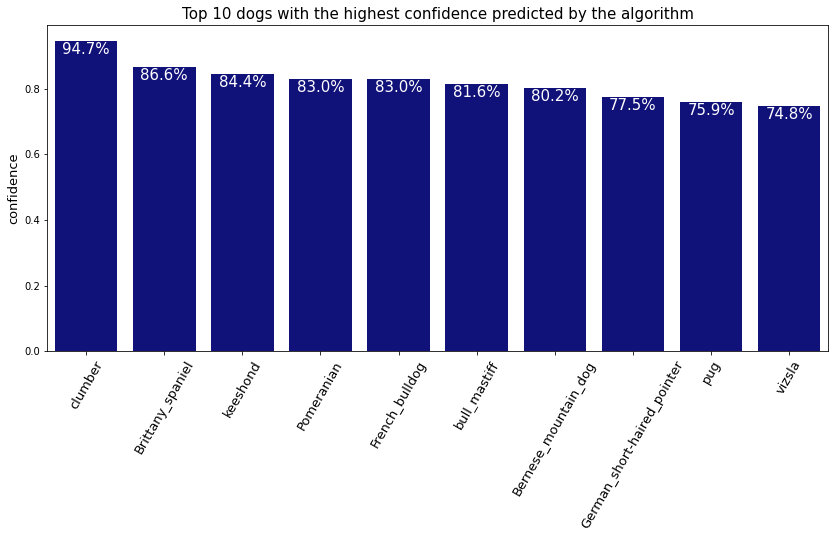

In [40]:
#defining a function to plot the breeds of dogs against their confidence
def dogs_barplot(dog_series, title, color):
    plt.figure(figsize=(14,6))
    sns.barplot(data=dog_series, x=dog_series.index.values, y='p1_conf', color=color)
    plt.ylabel('confidence', fontsize=13)
    plt.xticks(rotation=60, fontsize=13)
    plt.title(title, fontsize=15)
    for i in range(dog_series.shape[0]):
        c = dog_series.iloc[i, 0]
        t = '{:.1f}%'.format(100 * c)
        plt.text(i, c-0.04, t, ha='center', fontsize=15, color='w')
    plt.show()


#aggregating the breeds of dogs for the first prediction with their respective means
dogs = df.groupby('p1')['p1_conf'].mean().sort_values(ascending=False).to_frame()

#title for the top 10 breeds of dogs with the highest confidence
top_10_title = 'Top 10 dogs with the highest confidence predicted by the algorithm'

#plotting the top 10 breeds of dogs with the highest confidence
dogs_barplot(dogs[:10], top_10_title, 'darkblue')

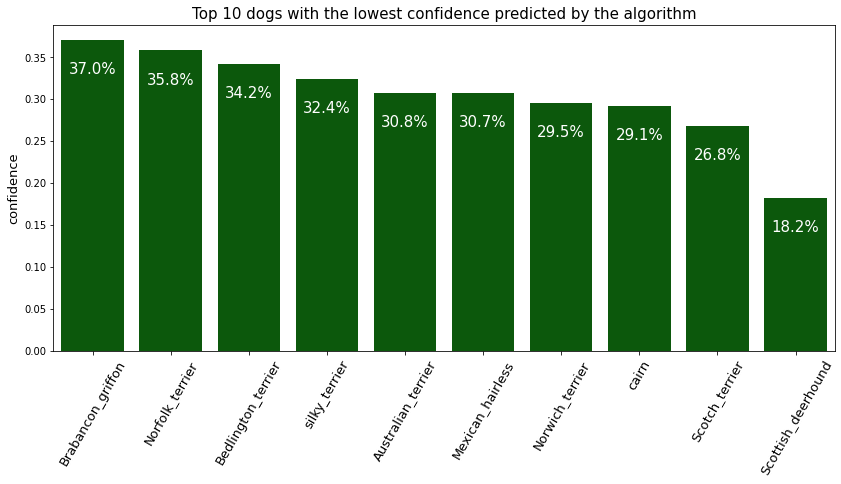

In [41]:
#title for the top 10 breeds of dogs with the highest confidence
low_10_title = 'Top 10 dogs with the lowest confidence predicted by the algorithm'

#plotting the top 10 breeds of dogs with the highest confidence
dogs_barplot(dogs[-10:], low_10_title, 'darkgreen')

### 2. Aggregating the breeds of dogs on the first prediction of the algorithm on the mean of the retweet counts in descending order.

In [42]:
#aggregating the breeds of dogs on the first prediction of the algorithm on the mean of the retweet counts in an descending order
dogs_retweets = df.groupby('p1')[['retweet_counts']].mean().sort_values('retweet_counts', ascending=False)

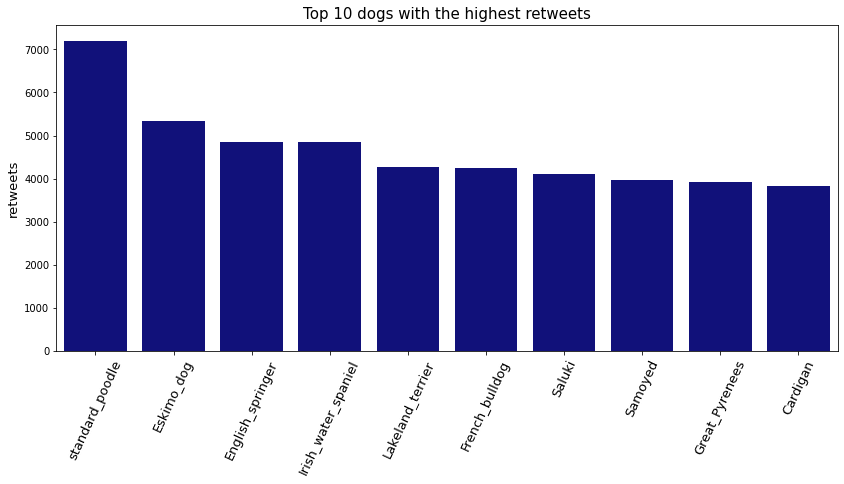

In [43]:
def barplot(dog_series, column, title, label, color):
    plt.figure(figsize=(14,6))
    sns.barplot(data=dog_series, x=dog_series.index.values, y=dog_series[column], color=color)
    plt.ylabel(label, fontsize=13)
    plt.xticks(rotation=65, fontsize=13)
    plt.title(title, fontsize=15)
    plt.show()

#title for the top 10 breeds of dogs with the highest retweet counts
top_10_retweets = 'Top 10 dogs with the highest retweets'

#plotting the top 10 breeds of dogs with the highest retweet counts
barplot(dogs_retweets[:10], 'retweet_counts', top_10_retweets, 'retweets', 'darkblue')

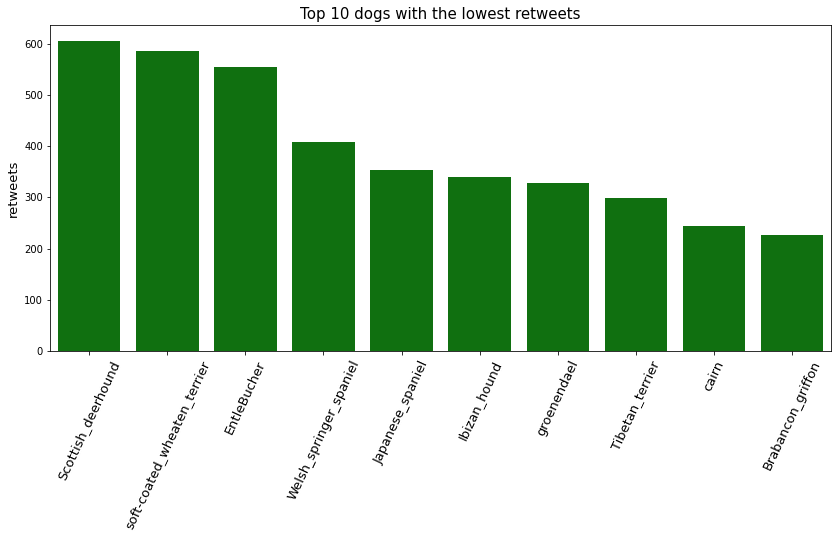

In [45]:
#title for the top 10 breeds of dogs with the lowest retweet counts
top_10_retweets = 'Top 10 dogs with the lowest retweets'

#plotting the top 10 breeds of dogs with the highest retweet counts
barplot(dogs_retweets[-10:], 'retweet_counts', top_10_retweets, 'retweets', 'green')

### 3. Aggregating the breeds of dogs on the first prediction of the algorithm on the mean of the favorite counts in descending order.

In [46]:
#aggregating the breeds of dogs on the first, second and third predictions of the algorithm on the mean of the favorite counts in an descending order
dogs_favorites = df.groupby('p1')[['favorite_counts']].mean().sort_values('favorite_counts', ascending=False)

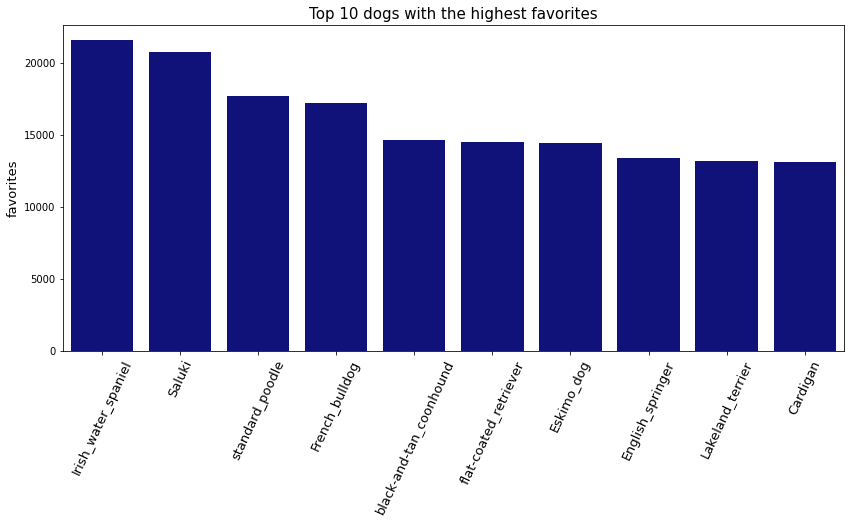

In [47]:
#title for the top 10 breeds of dogs with the highest favorite counts
top_10_favorites = 'Top 10 dogs with the highest favorites'

#plotting the top 10 breeds of dogs with the highest favorite counts
barplot(dogs_favorites[:10], 'favorite_counts', top_10_favorites, 'favorites', 'darkblue')

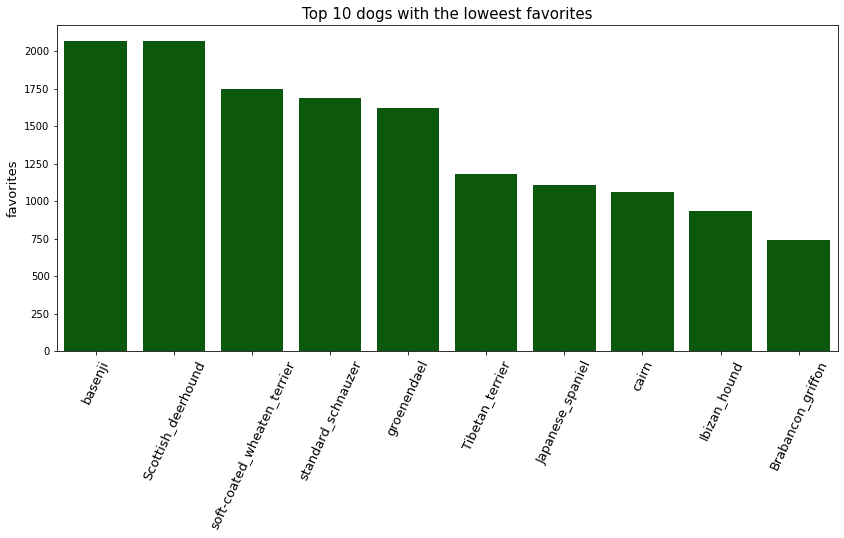

In [49]:
#title for the top 10 breeds of dogs with the lowest favorite counts
top_10_favorites = 'Top 10 dogs with the loweest favorites'

#plotting the top 10 breeds of dogs with the highest favorite counts
barplot(dogs_favorites[-10:], 'favorite_counts', top_10_favorites, 'favorites', 'darkgreen')

###  Visualization

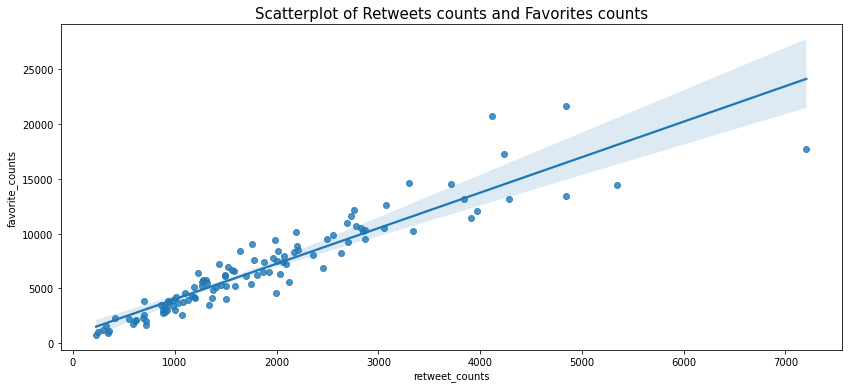

In [50]:
#visualizing the relationship between retweets and favorite likes
plt.figure(figsize=(14,6))
dogs_retweets_favorites = df.groupby('p1')[['retweet_counts', 'favorite_counts']].mean().dropna()
sns.regplot(data=dogs_retweets_favorites, x='retweet_counts', y='favorite_counts');
plt.title('Scatterplot of Retweets counts and Favorites counts', fontsize=15)
plt.show();

In [51]:
#mathematical representation of the relationship between retweets and favorite likes
retweets_favorites_corr = dogs_retweets_favorites['retweet_counts'].corr(dogs_retweets_favorites['favorite_counts'])
round(retweets_favorites_corr, 2)

0.93

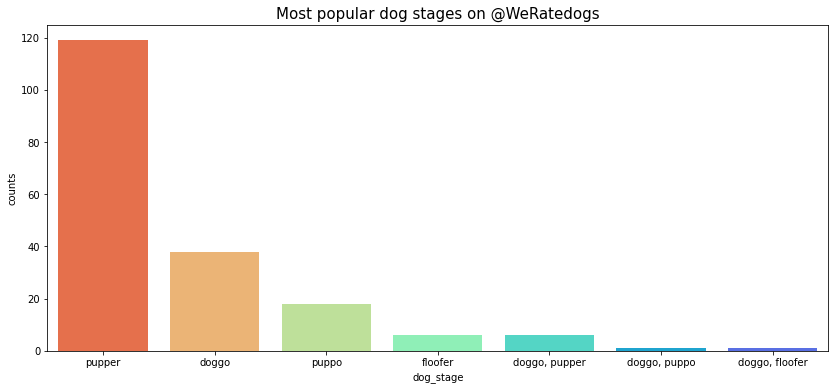

In [52]:
#visualizng the most popular dog status in the dataset
plt.figure(figsize=(14,6))
popular_dog_stages = df['dog_stage'].value_counts()[1:].reset_index()
popular_dog_stages.columns = ['dog_stage', 'counts']
sns.barplot(data=popular_dog_stages, x='dog_stage', y='counts', palette='rainbow_r')
plt.title('Most popular dog stages on @WeRatedogs', fontsize=15);
plt.savefig('most_popular_dog_stage.jpg');

### Creating a WordCloud

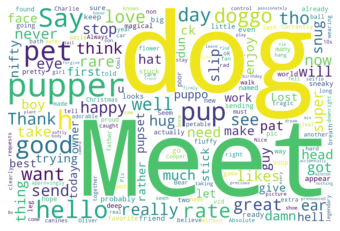

In [74]:
#parsing the values of the text column with the python function: join to form a string
text = ' '.join(df['text'])

#creating a variable stopword and updating it with new words
stopwords = STOPWORDS
stopwords.update(['know','one','still','Please', 'tongue','help','fucking','quite','look','af','back','someone','ckin','amp','time'])

#creatinfg the variable wordcloud
wordcloud = WordCloud(collocations=False,
                     width = 1200, height = 800,
                     background_color='white',
                     stopwords = stopwords).generate(text)

#visualizing the wordcloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

#save to file
plt.savefig('werate-wordcloud.png', format='png')

plt.show()